In [1]:
#Libraries
using Gen
using PyPlot
using Distributions
using LinearAlgebra
using Flux
#using ForwardDiff
#using ProgressMeter
#using BenchmarkTools;

┌ Warning: `haskey(::TargetIterator, name::String)` is deprecated, use `Target(; name = name) !== nothing` instead.
│   caller = llvm_compat(::VersionNumber) at compatibility.jl:176
└ @ CUDAnative C:\Users\jbere\.julia\packages\CUDAnative\ierw8\src\compatibility.jl:176


In [41]:
#Hyperparameters
n = 50
N = 200
σₐ = 0.001
k_range = 4
k_list = [1,2,3,4] #November 3
k_list_lite = [i for i in 1:k_range];

In [13]:
#Functions
function plot_data(data,classes,alpha=1.0)
    markers = ["o","*"]
    colors = ["blue","green"]
    for i=1:2
        mask = [classes[j] == i for j in 1:length(classes)]
        scatter(data[:,1][mask],data[:,2][mask],c=colors[i],alpha=alpha,marker=markers[i],zorder=3)
    end
end;

function unpack(Θ,k)
    m = length(Θ)
    h = 2*k
    Wₕ = reshape(Θ[1:h], k, 2);   
    bₕ = reshape(Θ[h+1:h+k], k)
    #bₕ = reshape(zeros(k), k)
    
    Wₒ = reshape(Θ[h+k+1:m-1], 1, k);
    bₒ = Θ[m]
    #bₒ = 0.0
      
    return Wₕ, bₕ, Wₒ, bₒ
end

function data_labeller(y::Array{Float64})
    labels = [y[i] > 0.5 ? 2 : 1 for i=1:length(y)]
    return labels
end

mₖ(k) = k*4 + 1;

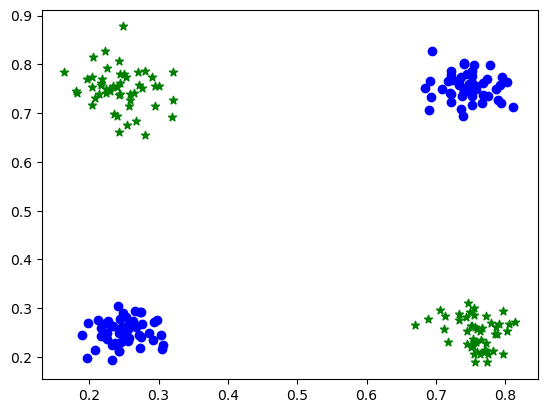

In [14]:
#Generate XOR Data
function real_data(N::Int, modes::Int, σ::Float64)
    μ₁ = [0.25, 0.25]
    μ₂ = [0.25, 0.75]
    μ₃ = [0.75, 0.75]
    μ₄ = [0.75, 0.25]
    #μ₅ = [1.25, 1.25]
    #μ₆ = [1.25, 1.75]
    #μ₇ = [1.75, 1.75]
    #μ₈ = [1.75, 1.25]
    μ = [μ₁, μ₂, μ₃, μ₄]
    Σ = [[σ, 0] [0, σ]]
    
    all_samples = zeros(Float64, (N*modes, 2))
    classes = zeros(Int, (N*modes))
    
    for i = 1:modes
        dist = MvNormal(μ[i], Σ)
        sample = rand(dist, N)::Matrix
        #scatter(sample[1,:],sample[2,:])
        all_samples[(i-1)*N+1:i*N,:] = transpose(sample)
        classes[(i-1)*N+1:i*N] = fill(i, N)
        classes = float(classes)
    end
    return all_samples, classes
end
    
data_raw, classes = real_data(Int(N/4), 4, σₐ);
classes = [(i+1) % 2 + 1 for i in classes]

plot_data(data_raw,classes)
data = transpose(data_raw)
size(data);

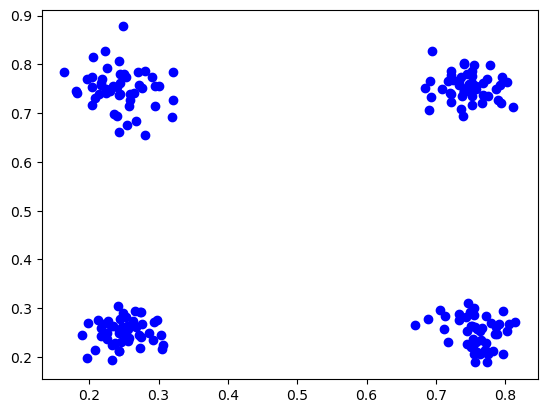

In [15]:
#Bayesian Neural Net
function G(x, W₁, b₁, W₂, b₂, k::Int)
    if(typeof(x) == Float64)
        x = [x]
    end
    
    W₁ = reshape(W₁, k, 2)
    W₂ = reshape(W₂, 1, k)
    b₁ = reshape(b₁, k)
    b₂ = reshape(b₂, 1)
    
    nn = Chain(Dense(W₁, b₁, relu),
               Dense(W₂, b₂))
    return nn(x)
end;

@dist k_count(r,p,min) = neg_binom(r,p) + 1

@gen function classifier(x::Array{Float64})
    σₖ = 100.0::Float64
    
    k ~ uniform_discrete(1,k_range) #Number of hidden nodes
    #k ~ k_count(1,0.5,1) #Shifted Negative Binomial
    #println(k)
    
    # Create the weight and bias vector.
    m = mₖ(k)
    h = 2*k
    
    μ₁ = zeros(h)
    Σ₁ = Diagonal([σₖ for i=1:length(μ₁)])
    Wₕ ~ mvnormal(μ₁,Σ₁)
    
    μ₂ = ones(k)
    Σ₂ = Diagonal([σₖ for i=1:length(μ₂)])
    bₕ ~ mvnormal(μ₂,Σ₂)
    
    μ₃ = zeros(k)
    Σ₃ = Diagonal([σₖ for i=1:length(μ₃)])
    Wₒ ~ mvnormal(μ₃,Σ₃)
    
    μ₄ = ones(1)
    Σ₄ = Diagonal([σₖ for i=1:length(μ₄)])
    bₒ ~ mvnormal(μ₄,Σ₄)

    
    #Return Network Scores for X
    scores = Flux.σ.(G(x,Wₕ,bₕ,Wₒ,bₒ,k))
    
    #Logistic Regression Likelihood
    y = @trace(mvnormal(vec(scores), Diagonal([0.01 for i=1:length(x[1,:])])), (:y))

    return scores
    
end;

predictions = classifier(data)
preds = data_labeller(predictions)
plot_data(data_raw,preds)

In [16]:
#Register Observed Data - Bernoulli
obs_master = choicemap()::ChoiceMap
obs_master[:y] = classes .- 1
obs = obs_master;

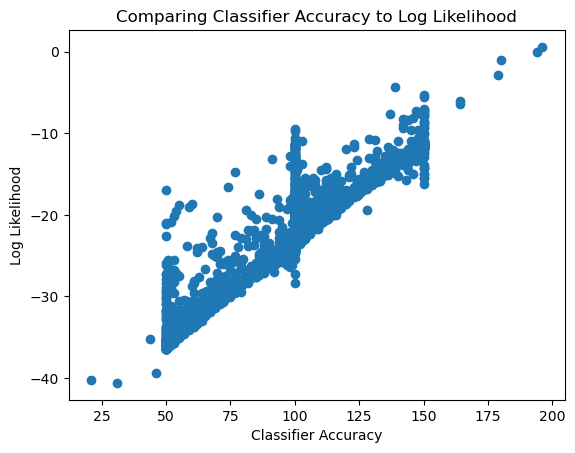

In [33]:
#Plot of Log Likelihood Scores
scores = []
accs = []
ks = []
(best_trace,) = generate(classifier, (data,), obs)
best_score = get_score(best_trace)/length(classes)
best_Wₕ = best_trace[:Wₕ]
best_Wₒ = best_trace[:Wₒ]
best_bₕ = best_trace[:bₕ]
best_bₒ = best_trace[:bₒ]
best_k = best_trace[:k]

best_pred_y = G(data,best_Wₕ,best_Wₒ,best_bₕ,best_bₒ,best_k)
best_pred_labels = data_labeller(best_pred_y)
best_acc = sum([best_trace[:y][i] == best_pred_labels[i] for i=1:length(classes)])/length(classes)

function likelihood(best_acc)
    (trace,) = generate(classifier, (data,), obs)
    
    Wₕ = trace[:Wₕ]
    Wₒ = trace[:Wₒ]
    bₕ = trace[:bₕ]
    bₒ = trace[:bₒ]
    k = trace[:k]
    pred_y = G(data,Wₕ,bₕ,Wₒ,bₒ,k)
    pred_labels = data_labeller(pred_y)

    acc = sum([classes[i] == pred_labels[i] for i=1:length(classes)])
    score = get_score(trace)/length(classes)
    if acc > best_acc
        best_score = score
        best_trace = trace
        best_acc = acc
        best_pred_labels = pred_labels
    end
    push!(scores,score)
    push!(accs,acc)
    push!(ks, k)
end

for i=1:10000
    likelihood(best_acc)
end

scatter(accs,scores)
plt.title("Comparing Classifier Accuracy to Log Likelihood")
plt.xlabel("Classifier Accuracy")
plt.ylabel("Log Likelihood");

In [36]:
traces = []
acc = []
ks = []

function within_dimension(trace, iters)
    for i=1:iters
        (trace, accepted) = hmc(trace, select(:Wₕ,:bₕ,:Wₒ,:bₒ), L=12, eps=0.05, check=false, observations=obs)
        #println("Within dimension: $(trace[:k])")
        push!(traces, trace)
        push!(acc, accepted)
    end
    return trace
end

#Need to find a way to propose birth/death moves instead of any k
function birth_or_death(trace)
    current_k = trace[:k]
    if current_k == last(k_list)
        new_trace = death(trace)
    else if current_k == k_list[1]
        new_trace = birth(trace)
    else
        new_trace = bernoulli(0.5) ? birth(trace) : death(trace)
    end
    return new_trace    
end

@gen function birth(trace)
    previous_k = trace[:k]
    new_k = k_list[previous_k + 1]
    
end

@gen function death(trace)
    previous_k = trace[:k]
    new_k = k_list[previous_k + 1]
    
end

function across_dimension(trace, iters, obs)
    selection = select(:Wₕ,:bₕ,:Wₒ,:bₒ,:k)
    args = get_args(trace)
    argdiffs = map((_) -> NoChange(), args)
    (new_trace, weight) = regenerate(trace, args, argdiffs, selection)
    
    new_trace = birth_or_death(trace[:k])
    
    test = true
    for i=1:50
        (new_trace, accepted) = hmc(new_trace, select(:Wₕ,:bₕ,:Wₒ,:bₒ), L=20, eps=0.01, check=false, observations=obs)
        accepted && (test = false)
    end
    test && println("Nothing accepted")
    
    score1 = exp(get_score(trace)/length(data))
    score2 = exp(get_score(new_trace)/length(data))
    score = score2/score1
    #println(score)
    
    if rand(Uniform(0,1)) < score
        accepted = true
        trace = new_trace
        new_k = trace[:k]
        #println("New k accepted! Current k: $(new_k)")
        push!(acc,true)
    else
        #println("Sticking with the old k!")
        accepted = false
        push!(acc,false)
    end
    
    obs = obs_master
    obs[:k] = trace[:k]
        
    push!(traces, trace)
    push!(acc, accepted)
    return trace, trace[:k]
end

function rjmcmc(starting_trace, iters)
    trace = starting_trace
    k = obs[:k]
    println("Beginning RJMCMC. Starting k: $k")
    #@showprogress 1 "Sampling..." for i = 1:iters
    for i=1:iters
        if i%500 == 0
            println("Epoch $i Acceptance Prob: $(sum(acc)/length(acc))")
        end
        
        if rand(Uniform(0,1)) > 0.95
            (trace, k) = across_dimension(trace, 1, obs)
        else
            (trace) = within_dimension(trace, 1)
        end
        push!(ks, k)
    end
    println("Finished")
end
 
starting_trace = best_trace
#(starting_trace,) = generate(classifier, (data,), obs)
obs[:k] = starting_trace[:k]
rjmcmc(starting_trace,30000);

Beginning RJMCMC. Starting k: 3
Epoch 500 Acceptance Prob: 0.720532319391635
Nothing accepted
Epoch 1000 Acceptance Prob: 0.6644612476370511
Nothing accepted
Epoch 1500 Acceptance Prob: 0.6677155443675268
Nothing accepted
Nothing accepted
Epoch 2000 Acceptance Prob: 0.6672985781990521
Epoch 2500 Acceptance Prob: 0.6742510428517254
Epoch 3000 Acceptance Prob: 0.630730319317104
Nothing accepted
Epoch 3500 Acceptance Prob: 0.6368821292775665
Nothing accepted
Epoch 4000 Acceptance Prob: 0.6462342599192207
Nothing accepted
Nothing accepted
Epoch 4500 Acceptance Prob: 0.6614638261970048
Nothing accepted
Nothing accepted
Nothing accepted
Epoch 5000 Acceptance Prob: 0.666920007600228
Epoch 5500 Acceptance Prob: 0.6674145667932344
Nothing accepted
Epoch 6000 Acceptance Prob: 0.6633428300094967
Epoch 6500 Acceptance Prob: 0.6711007162695513
Nothing accepted
Epoch 7000 Acceptance Prob: 0.6813186813186813
Epoch 7500 Acceptance Prob: 0.6893449892309641
Nothing accepted
Epoch 8000 Acceptance Prob: 0

In [95]:
print(best_trace)

Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}(DynamicDSLFunction{Any}(Dict{Symbol,Any}(), Dict{Symbol,Any}(), Type[Array{Float64,N} where N], false, Union{Nothing, Some{Any}}[nothing], ##classifier#366, Bool[0], false), Trie{Any,Gen.ChoiceOrCallRecord}(Dict{Any,Gen.ChoiceOrCallRecord}(:Wₒ => Gen.ChoiceOrCallRecord{Array{Float64,1}}([6.0355911733793155, 1.5115661474159992, -5.797770426100075], -10.026207553315901, NaN, true),:k => Gen.ChoiceOrCallRecord{Int64}(3, -1.3862943611198906, NaN, true),:y => Gen.ChoiceOrCallRecord{Array{Float64,1}}([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

, [1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 0.9999999999999183 0.9999999999999749 0.9999999999998708 0.9999999999999734 0.9999999999999674 0.9999999999999962 0.9999999999999669 0.9999999999998463 0.9999999999998503 0.9999999999999329 0.9999999999999869 0.9999999999999651 0.9999999999998861 0.9999999999999631 0.9999999999999771 0.9999999999999165 0.9999999999999867 0.999999999999954 0.9999999999999929 0.9999999999999729 0.9999999999999769 0.9999999999999534 0.9999999999999807 0.9999999999990214 0.9999999999999505 0.9999999999999905 0.9999999999999925 0.999999999999923 0.9999999999999751 0.9999999999999771 0.9999999999999927 0.999999999999853 0.9999999999997962 0.9999999999999545 0.9999999999999938 0.9999999999999121 0.9999999999999247 0.9999999999999931 0.9999999999999822 0.999999999999992 0.9999999999998104 0.999999999999855 0.99

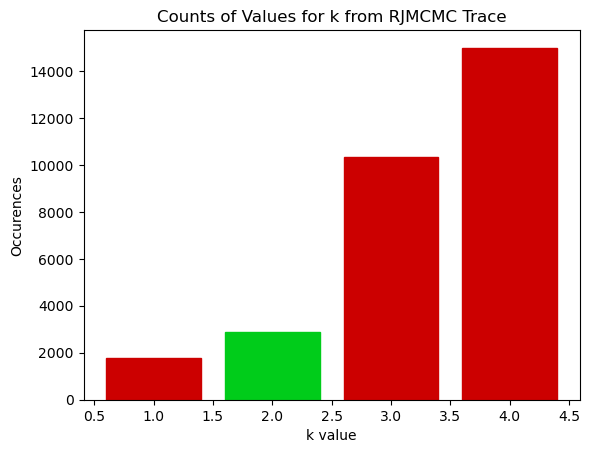

In [37]:
#Bar Plot of k estimates
#ks = [traces[i][:k] for i in 1:length(traces)]
counts = [sum([ks[i] == j for i in 1:length(ks)]) for j in k_list]
barlist=bar(k_list,counts)
for i in 1:k_range
    barlist[i].set_color([0.8,0.0,0.0])
end
barlist[2].set_color([0.0,0.8,0.1])

plt.title("Counts of Values for k from RJMCMC Trace")
plt.xlabel("k value")
plt.ylabel("Occurences");

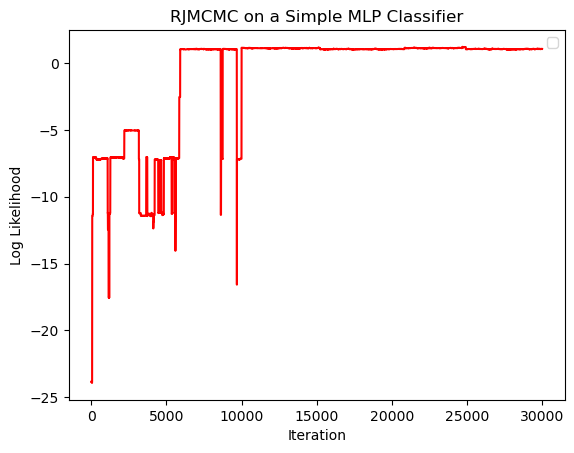

No handles with labels found to put in legend.


In [38]:
#hmc_traces_master = vcat(hmc_traces, hmc_traces2, hmc_traces3, hmc_traces4);
scores2 = zeros(length(traces))
for i=1:length(traces)
    trace = traces[i]
    obs = obs_master
    scores2[i] = get_score(trace)/length(classes)
end
plot(scores2, color="red")
#plot(scores2, color="green")
plt.title("RJMCMC on a Simple MLP Classifier")
plt.xlabel("Iteration")
plt.ylabel("Log Likelihood")
#plt.axvline(100,label="Burn-In: ~1000",color="red")
plt.legend();

In [55]:
index = 1

1

In [40]:
#Uncertainty Plotting
x_grid = zeros((20000,2));
for i=1:20000
    x_grid[i,:] = rand(1,2)
end
x_grid2 = transpose(x_grid);
print(size(x_grid2))
print(size(data))

function plot_many(index)
    obs_sample = choicemap()::ChoiceMap
    obs_sample[:k] = traces[index][:k]
    obs_sample[:Θ] = traces[index][:Θ]
    (trace_pred, _) = generate(classifier, (x_grid2,), obs_sample)
    #predict_scores = [trace_pred[(:y,i)] for i=1:length(x_grid[:,1])]
    predict_scores = trace_pred[:y]
    predict_labels = data_labeller(predict_scores)
    plot_data(x_grid, predict_labels, 0.002)
end


for i=1:300
    index = rand((1000,30000))
    plot_many(index)
end

#index += 10
#print(index)

#plt.title("Basic Uncertainty Visualization: RJMCMC-HMC");

(2, 20000)(2, 200)

ErrorException: No random choice or generative function call at address Θ